<a href="https://colab.research.google.com/github/abyki/ml/blob/main/hw1_akaev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from random import sample
import os
from datetime import datetime, timedelta
from calendar import monthrange

In [2]:
df = pd.read_csv('Shanghai_HMT_2010.csv')

In [3]:
df.sample(5)

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
21964,21965,2012,7,4,4,2,NaN,15.0,NaN,23.0,83.60,1002.0,26.0,SE,3.0,0.0,0.0
10950,10951,2011,4,2,6,1,NaN,NaN,NaN,12.0,87.75,1016.9,14.0,NE,13.0,0.0,0.0
23796,23797,2012,9,18,12,3,NaN,72.0,NaN,14.0,47.61,1010.8,26.0,NW,36.0,0.0,0.0
42568,42569,2014,11,9,16,3,50.0,54.0,47.0,8.0,55.41,1023.0,17.0,NE,40.0,0.0,0.0
50301,50302,2015,9,27,21,3,30.0,25.0,25.0,18.0,73.50,1014.0,23.0,NE,92.0,0.0,0.0


In [4]:
df.shape

(52584, 17)

In [5]:
df[df.isna().any(axis=1)].shape

(31148, 17)

In [6]:
df.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015])

In [7]:
df.dropna(inplace=True)

In [8]:
df.sample(10)

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
49502,49503,2015,8,25,14,2,48.0,34.0,38.0,20.0,55.15,1004.0,30.0,NW,115.0,0.0,0.0
44960,44961,2015,2,17,8,4,172.0,166.0,168.0,5.0,81.34,1022.0,8.0,NE,36.0,0.0,0.0
43574,43575,2014,12,21,14,4,86.0,83.0,71.0,-11.0,28.27,1029.0,6.0,NW,57.0,0.0,0.0
32883,32884,2013,10,2,3,3,48.0,41.0,50.0,17.0,82.89,1015.0,20.0,NW,11.0,0.0,0.0
27895,27896,2013,3,8,7,1,170.0,188.0,191.0,7.0,76.35,1012.0,11.0,SE,33.0,0.0,0.0
31780,31781,2013,8,17,4,2,5.0,4.0,11.0,23.0,70.17,1003.0,29.0,SE,87.0,0.0,0.0
28558,28559,2013,4,4,22,1,40.0,39.0,32.0,12.0,82.27,1011.0,15.0,SE,191.0,0.0,0.0
33373,33374,2013,10,22,13,3,38.0,37.0,41.0,12.0,56.44,1021.0,21.0,NE,32.0,0.0,0.0
50802,50803,2015,10,18,18,3,25.0,31.0,24.0,12.0,53.10,1019.0,22.0,NE,26.0,0.0,0.0
29021,29022,2013,4,24,5,1,81.0,82.0,87.0,11.0,87.66,1013.0,13.0,NE,3.0,0.0,0.0


In [9]:
df = df.sort_values(by=['year', 'month', 'day', 'hour'])

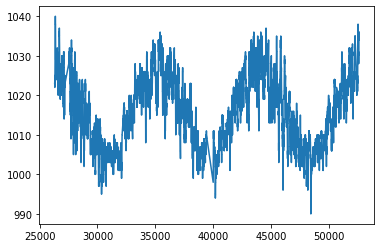

In [10]:
plt.plot(df.PRES)

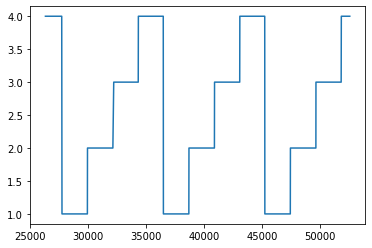

In [11]:
plt.plot(df.season)

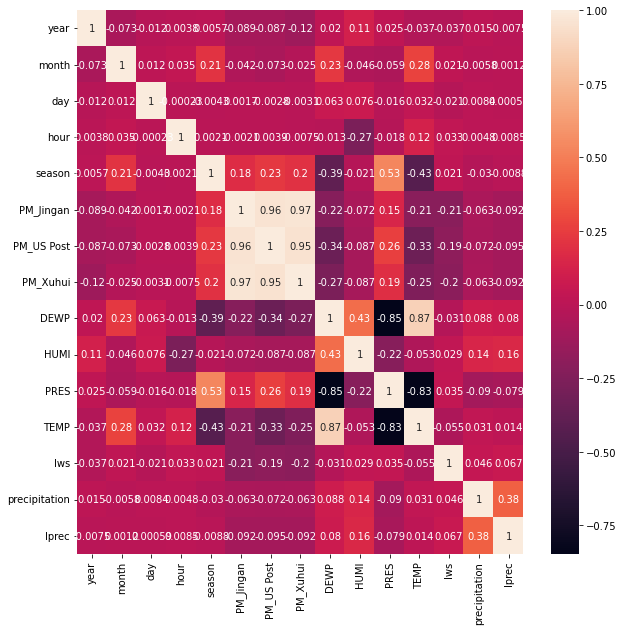

In [12]:
corr_cols = ['year', 'month', 'day', 'hour', 'season', 'PM_Jingan',
             'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
             'precipitation', 'Iprec']

plt.figure(figsize=(10, 10))
sns.heatmap(df[corr_cols].corr(method="pearson"), annot=True)
plt.show()

In [13]:
df.hour.unique()

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  2, 12])

In [14]:
df['month_sin'] = np.sin(2 * np.pi * df.month / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df.month / 12.0)

df['hour_sin'] = np.sin(2 * np.pi * df.hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df.hour / 24.0)

df['day_of_month_sin'] = df.apply(lambda r: np.sin(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)
df['day_of_month_cos'] = df.apply(lambda r: np.cos(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)

In [15]:
df.year.unique()

array([2013, 2014, 2015])

In [16]:
df_train = df[df.year < 2015]
df_val = df[df.year >= 2015]

In [17]:
df_train.shape, df_val.shape

((14587, 23), (6849, 23))

In [21]:
!pip install category_encoders
from category_encoders import (
    JamesSteinEncoder, 
    CatBoostEncoder, 
    TargetEncoder
)

     |████████████████████████████████| 82 kB 345 kB/s 


In [19]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
ce_target = TargetEncoder(cols = ['cbwd'])

ce_target.fit(df_train.cbwd, df_train.PRES)

df_train['cbwd_te'] = ce_target.transform(df_train.cbwd).cbwd.values
df_val['cbwd_te'] = ce_target.transform(df_val.cbwd).cbwd.values

In [23]:
df_train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Jingan',
       'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws',
       'precipitation', 'Iprec', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'day_of_month_sin', 'day_of_month_cos', 'cbwd_te'],
      dtype='object')

In [24]:
used_cols = ['year', 'month_sin', 'month_cos', 'day_of_month_sin',
             'day_of_month_cos', 'hour_sin', 'hour_cos', 
             'cbwd_te', 'season', 'PM_Jingan',
             'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'TEMP', 'Iws',
             'precipitation', 'Iprec']
target = 'PRES'

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df_train[used_cols])
x_val = sc.transform(df_val[used_cols])

In [26]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, df_train[target].values)

LinearRegression()

In [27]:
for c, coef in zip(used_cols, list(reg.coef_)):
    print(f'{coef}\t{c}')

0.11001085502675781	year
-0.676136354826355	month_sin
3.2591848823314686	month_cos
-0.08723440662662715	day_of_month_sin
-0.17200886018948933	day_of_month_cos
0.19008181063063143	hour_sin
-0.33952427204800595	hour_cos
0.15771533781583666	cbwd_te
-0.5926919654221375	season
0.26674726114793906	PM_Jingan
-0.010391811417192061	PM_US Post
-0.8866424557311626	PM_Xuhui
4.008882704268333	DEWP
-3.75399056029444	HUMI
-9.632552178956907	TEMP
-0.1682168498497284	Iws
-0.14253423398689513	precipitation
-0.15860626494768632	Iprec


In [28]:
reg.intercept_

1016.1497909097142

In [29]:
y_pred = reg.predict(x_val)

In [30]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
def report(y_true, y_pred):
    print('MSE:  {}'.format(mean_squared_error(y_true, y_pred)))
    print('MAE:  {}'.format(mean_absolute_error(y_true, y_pred)))
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [31]:
report(df_val[target].values, y_pred)

MSE:  13.33775132910316
MAE:  2.8161580375771202
MAPE: 0.0027693951227232548


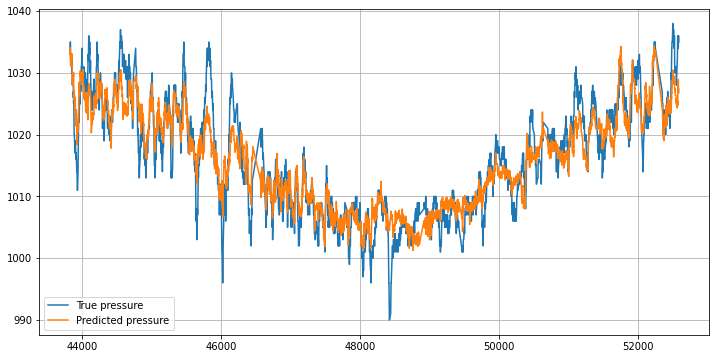

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_val.index, df_val.PRES, label='True pressure')
plt.plot(df_val.index, y_pred, label='Predicted pressure')
plt.legend()
plt.grid()
plt.show()


* дисперсия предсказанных значений меньше


* Достаточно неплохо предсказали давление (MAE = 2.8 hPa), не используя при этом никаких дополнительных признаков вроде скользящих окон. Видимо, поведение давление в первом приближении уже хорошо объясняется динамикой температуры, влажности и точки росы






